In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense , Dropout
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.preprocessing import normalize
import os
import numpy as np
import json 
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import shutil 
import math

## Loading Data

In [ ]:
label_map = {i:index for index,i in enumerate(os.listdir("training_data"))}
max_test = 20 
train_names , test_names = [] , []
X_train , X_test , y_train , y_test = [] , [], [], []
for action in os.listdir("training_data"):
    count = 0
    count_overall = 0 
    for sequence in np.array(os.listdir(os.path.join("training_data", action)) , dtype=object):
        window = []
        for frame_num in range(30):
            res = np.load(os.path.join("training_data", action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
            
        if "_" in sequence or count == max_test: #check if video is augmented ( _ -> augmented) to omit augmentations from testing
            X_train.append(window)  #window is array of 30 frames(1 video)
            train_names.append(sequence)
            y_train.append(label_map[action])
        else: 
            X_test.append(window)
            test_names.append(sequence)
            y_test.append(label_map[action])
            count +=1




## Shuffling data

In [29]:
def shuffle(Images , Labels):
    arr = [(image , label) for image, label in zip (Images,Labels)]
    np.random.shuffle(arr)
    X = [i[0] for i in arr]
    Y = [i[1] for i in arr]
    return X , Y

In [30]:
X_train, y_train= shuffle(X_train , y_train) 
X_test, y_test = shuffle(X_test , y_test) 

## Convert labels matrices to categorical matrices

In [31]:
y_train = to_categorical(y_train).astype(int)
y_test = to_categorical(y_test).astype(int)

In [32]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [36]:
print("Training Data Shape:"  , X_train.shape)
print("Training Labels Shape:"  ,y_train.shape)
print("Teting Data Shape:" , X_test.shape)
print("Testing Labels Shape:" ,  y_test.shape)

Training Data Shape: (5543, 30, 126)
Training Labels Shape: (5543, 60)
Teting Data Shape: (1179, 30, 126)
Testing Labels Shape: (1179, 60)


## Model Architecture

In [44]:
model = Sequential()
model.add(LSTM(512, return_sequences=True, activation='tanh', input_shape=(30,126)))
model.add(Dropout(0.3))
model.add(LSTM(512, return_sequences=True, activation='tanh'))
model.add(Dropout(0.3))
model.add(LSTM(512, return_sequences=False, activation='tanh'))
model.add(Dense(512, activation='relu',activity_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu',activity_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(60, activation='softmax'))

In [45]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

In [47]:
import datetime
log_dir = "logs1/mymodel3"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## Training Model

In [48]:
Model = model.fit(X_train, y_train,batch_size = 256, epochs=500,  validation_data=(X_test,y_test),callbacks=[tensorboard_callback])

Epoch 1/500
22/22 [==============================] - 19s 667ms/step - loss: 4.0292 - acc: 0.0539 - val_loss: 3.8456 - val_acc: 0.0789
Epoch 2/500
22/22 [==============================] - 14s 647ms/step - loss: 3.7527 - acc: 0.0909 - val_loss: 3.5856 - val_acc: 0.1052
Epoch 3/500
22/22 [==============================] - 13s 623ms/step - loss: 3.5525 - acc: 0.1196 - val_loss: 3.4075 - val_acc: 0.1179
Epoch 4/500
22/22 [==============================] - 13s 617ms/step - loss: 3.3748 - acc: 0.1461 - val_loss: 3.2127 - val_acc: 0.1705
Epoch 5/500
22/22 [==============================] - 13s 611ms/step - loss: 3.2151 - acc: 0.1806 - val_loss: 3.0816 - val_acc: 0.2222
Epoch 6/500
22/22 [==============================] - 13s 601ms/step - loss: 3.1181 - acc: 0.2129 - val_loss: 2.9132 - val_acc: 0.2485
Epoch 7/500
22/22 [==============================] - 13s 610ms/step - loss: 2.9979 - acc: 0.2464 - val_loss: 2.8847 - val_acc: 0.2392
Epoch 8/500
22/22 [==============================] - 10s 449ms

## Visualization

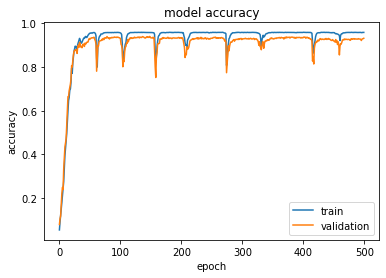

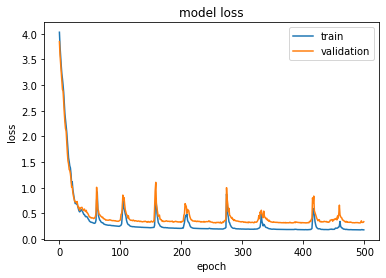

In [49]:
# list all data in history
# summarize history for accuracy
plt.plot(Model.history['acc'])
plt.plot(Model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(Model.history['loss'])
plt.plot(Model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [19]:
model.save("C:/Users/CSE-P07-2178-08/Desktop/Thesis Final Presentation Stuff/Results Final/100 classes/100classes.h5")

## Testing

In [128]:
yhat = model.predict(X_test)

In [129]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [130]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix( ytrue, yhat)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [131]:
Labels = list(label_map.keys())

## Visualizing Predictions

<AxesSubplot:>

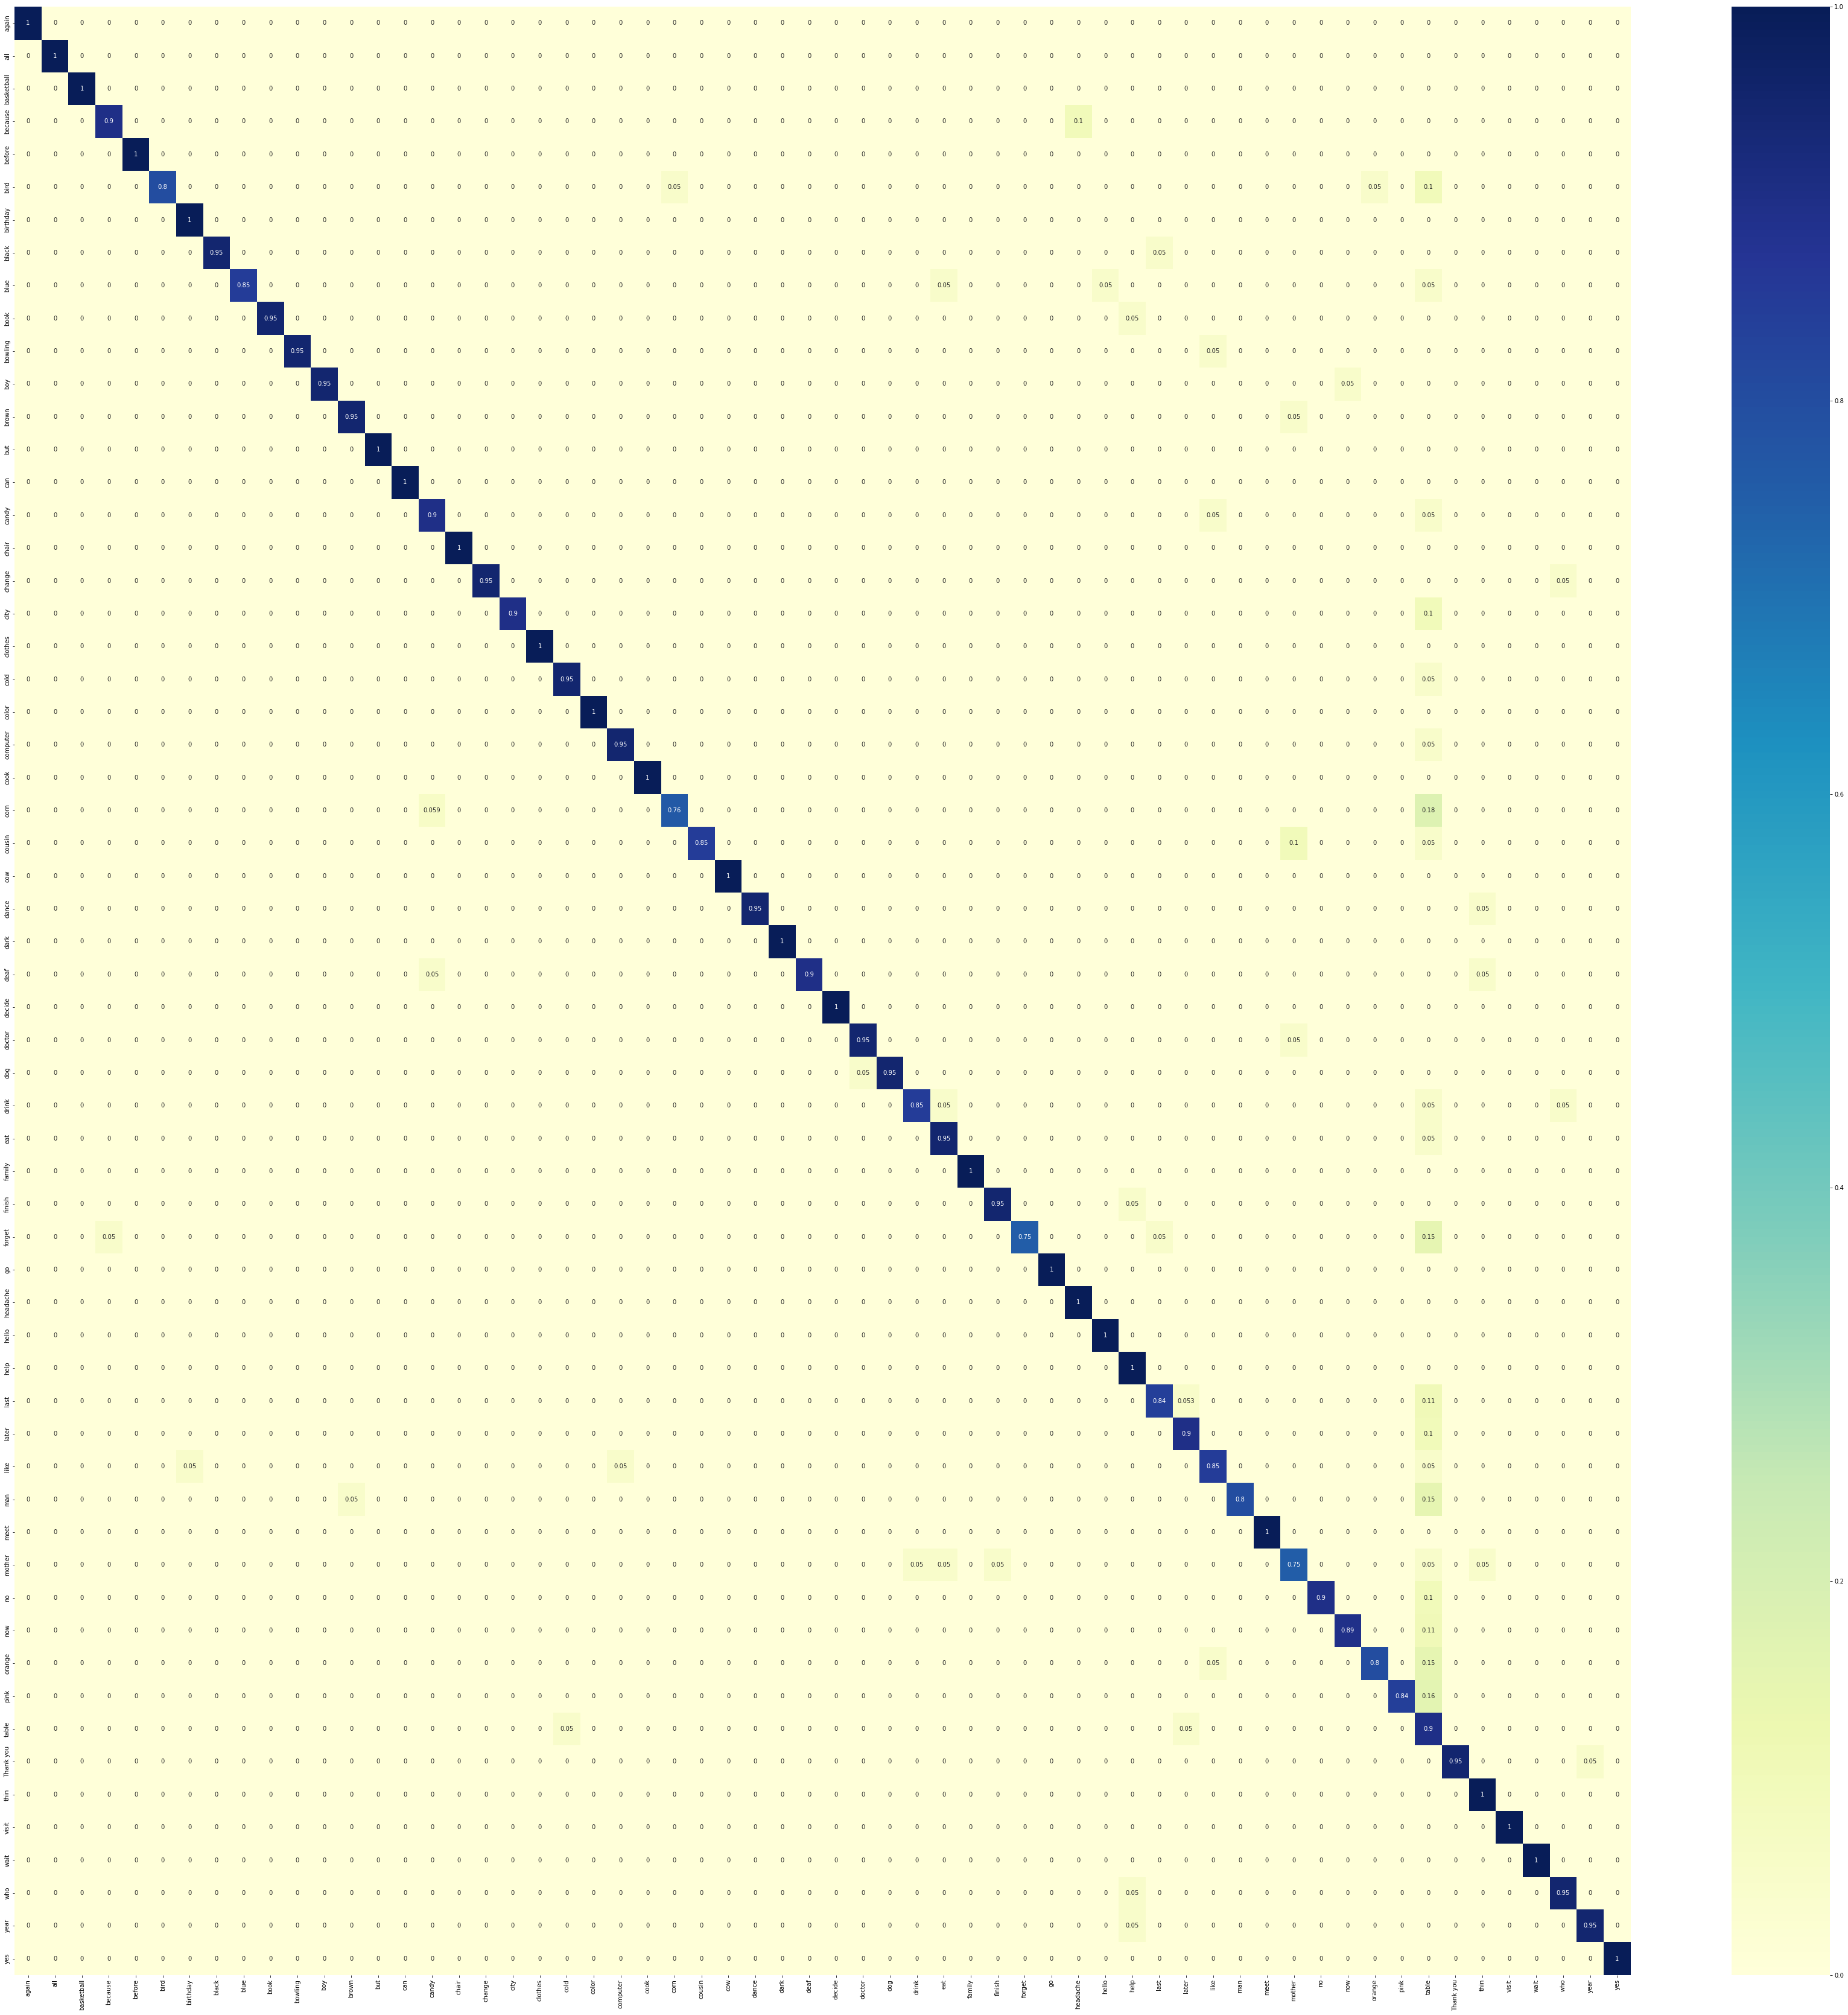

In [132]:
import pandas as pd 
import seaborn as sn

df_cm = pd.DataFrame(cm, index = [i for i in Labels],
                  columns = [i for i in Labels])
plt.figure(figsize = (cm.shape))
sn.heatmap(df_cm, annot=True , cmap="YlGnBu")